<h1>Correcting batch effects</h1>

In this notebook we revisit the `variance` module to deploy the Harmony algorithm for correcting batch effect.

In [1]:
# CytoPy imports
from cytopy.data.project import Project
from cytopy.data.setup import global_init
from cytopy.flow.plotting import single_cell_plot
from cytopy.flow.dim_reduction import dimensionality_reduction
from cytopy.flow import variance
# Connect to local database
global_init("cytopy_db")

In [2]:
# Other imports
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set(style="white", font_scale=1.2)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [3]:
# Load project and experiment
peritonitis_project = Project.objects(project_id="Peritonitis").get()
exp = peritonitis_project.load_experiment("PBMC T cells")

In [4]:
features = ['FSC-A', 'FSC-H', 'SSC-A', 'SSC-W', 'CXCR3', 'CD161',
           'CCR7', 'Va7-2', 'CD8', 'Vd2', 'CD45RA', 'PanGD', 'CD4',
           'CD27']

When we correct batch effect it will generate new `FileGroup`'s with the corrected data housed within. This means we don't lose any information from our original data. We can store the corrected data within the same project but to stay organised we like to create a new experiment to house this data. This is preferable in this case because we won't be keeping all the channels from the original data, only those listed in the above variable `features`. The `variance` module has a convenient function to create such an experiment.

In [5]:
corrected_exp = variance.create_experiment(project=peritonitis_project,
                                           features=features,
                                           experiment_name="Corrected PBMC T cells")

<h2>Harmony</h2>

The harmony algorithm is deployed using the `Harmony` class. We specify the experiment we want to load data from, the features to use and which population to sample. Harmony is computationally expensive so we want to downsample our data before performing batch correction. We also specify to perform logicle transformation of our data to make it more meaningful and by default `Harmony` will scale features to have unit variance.

Details regarding the Harmony algorithm itself can be found in the original publications [1, 2] and in our accompanying manuscript.

[1] Korsunsky et al. Fast, sensitive and accurate integration of single-cell data with Harmony (https://www.nature.com/articles/s41592-019-0619-0)

[2] Slowikowski. https://github.com/slowkow/harmonypy

In [5]:
import logging
harmony = variance.Harmony(experiment=exp,
                           features=features,
                           population="ag_T cells",
                           logging_level=logging.INFO,
                           transform="logicle",
                           sample_size=10000)

  0%|          | 0/14 [00:00<?, ?it/s]

<h3>Before correction</h3>

Before we apply the harmony algorithm, let's take a look at the batch effect. We can generate a UMAP plot of overlaid samples by first using the `dimensionality_reduction` function, which will return our dataframe with embeddings as new columns. Then we use the `single_cell_plot` function to plot our data. We will keep the `reducer` to embed batch corrected data in the same space.

In [6]:
data, reducer = dimensionality_reduction(data=harmony.data,
                                        features=harmony.features,
                                        method="UMAP",
                                        n_components=2,
                                        return_reducer=True)

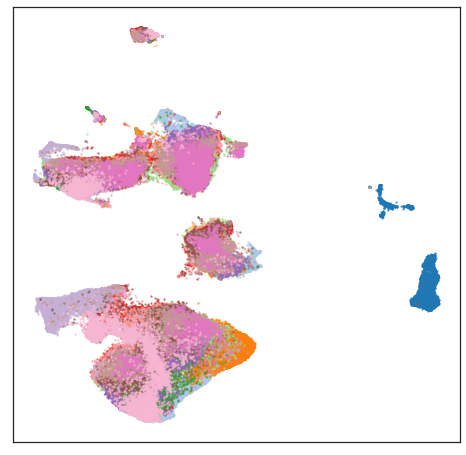

In [7]:
ax = single_cell_plot(data=data,
                      x="UMAP1",
                      y="UMAP2",
                      label="sample_id",
                      discrete=True,
                      linewidth=0,
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/before_correction.png", dpi=300, bbox_inches="tight", facecolor="white")

We see large regions occupied by individual samples. There is cell structure common between samples as shown below by plotting the expression of T cell markers. But we want to diffuse these groups of densely packed cells from single samples. Let's look at what cell types constitute these structures by colouring events by a chosen column; the `single_cell_plot` makes this easy to define with the `label` parameter and takes additional arguments to control the colour mapping.

This type of plotting can be repeated after our batch effect correction to ensure that our application of Harmony has not deducted the biological meaning described by the structures we see in this low dimension embedding.

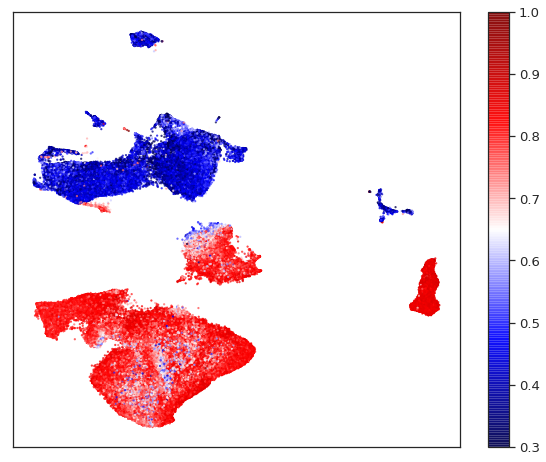

In [8]:
ax = single_cell_plot(data=data,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD4",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      cmap="seismic",
                      norm=Normalize(vmin=0.3, vmax=1),
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/before_correction_CD4.png", dpi=300, bbox_inches="tight", facecolor="white")

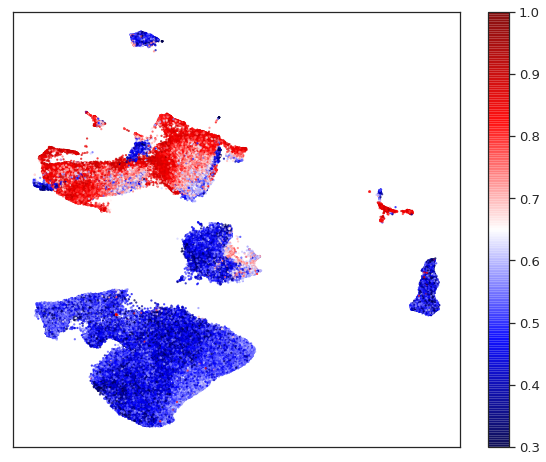

In [9]:
ax = single_cell_plot(data=data,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD8",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      cmap="seismic",
                      norm=Normalize(vmin=0.3, vmax=1),
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/before_correction_CD8.png", dpi=300, bbox_inches="tight", facecolor="white")

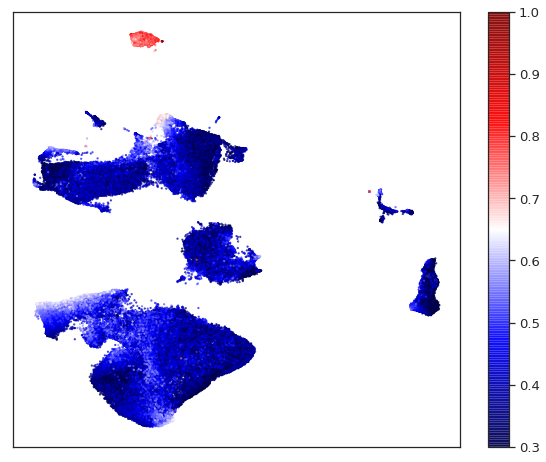

In [10]:
data["PanGD + Vd2"] = data["PanGD"] + data["Vd2"]
ax = single_cell_plot(data=data,
                      x="UMAP1",
                      y="UMAP2",
                      label="PanGD + Vd2",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      cmap="seismic",
                      norm=Normalize(vmin=0.3, vmax=1),
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/before_correction_GDT.png", dpi=300, bbox_inches="tight", facecolor="white")

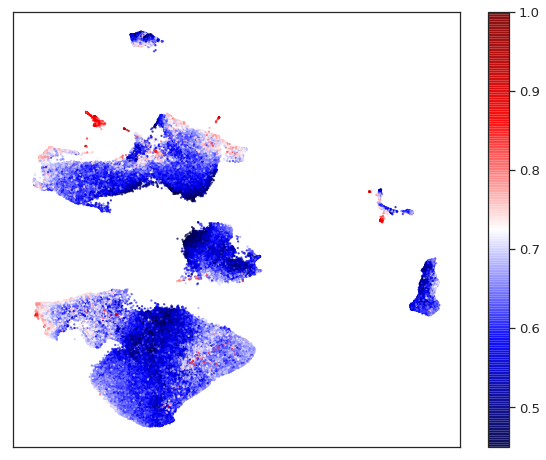

In [11]:
from matplotlib.colors import Normalize
data["CD161 + Va7-2"] = data["CD161"] + data["Va7-2"]
ax = single_cell_plot(data=data,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD161 + Va7-2",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      cmap="seismic",
                      scale="minmax",
                      norm=Normalize(vmin=0.45, vmax=1),
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/before_correction_MAIT.png", dpi=300, bbox_inches="tight", facecolor="white")

<h3>After correction</h3>

We apply the harmony algorithm using the `run` method. We chose to limit the number of iterations to 5 and a sigma of 0.2. These hyperparameters have the greatest influence when working with cytometry data but take some experimentation to choose.

In [12]:
harmony.run(sigma=0.2, max_iter_harmony=5)

2021-03-04 10:05:17,723 - harmonypy - INFO - Iteration 1 of 5
2021-03-04 10:05:55,597 - harmonypy - INFO - Iteration 2 of 5
2021-03-04 10:06:33,520 - harmonypy - INFO - Iteration 3 of 5
2021-03-04 10:07:12,783 - harmonypy - INFO - Iteration 4 of 5
2021-03-04 10:07:49,119 - harmonypy - INFO - Iteration 5 of 5
2021-03-04 10:08:25,528 - harmonypy - INFO - Stopped before convergence


Something that helps with choosing hyperparameters is by plotting the LISI distribution before and after applying harmony. This is achieved using the `batch_lisi_distribution` method:

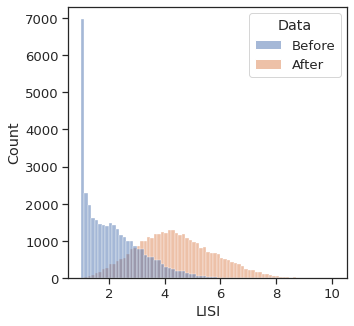

In [23]:
harmony.batch_lisi_distribution(sample=0.25)
plt.savefig("figures/LISI.png", dpi=300, facecolor="white", bbox_inches="tight")

The LISI is a measure of the number of batches in a local neighbourhood of a cell and therefore a shift towards the right is what we want to see. An even more effective way of observing the quality of batch correction is by repeating the plots UMAP plots we showed above. We collect the batch corrected data as an equivalent DataFrame using the `batch_corrected` method.

As shown below, cells are more evently distributed whilst biologically meaningful populations are retained. We use the same UMAP `reducer` that was applied before to project our corrected data into the same space.

We will also colour our events by cell surface markers to ensure that meaningful structure is retained.

In [16]:
data = harmony.batch_corrected()
embeddings = reducer.transform(data[harmony.features])

In [17]:
data["UMAP1"], data["UMAP2"] = embeddings[:, 0], embeddings[:, 1]

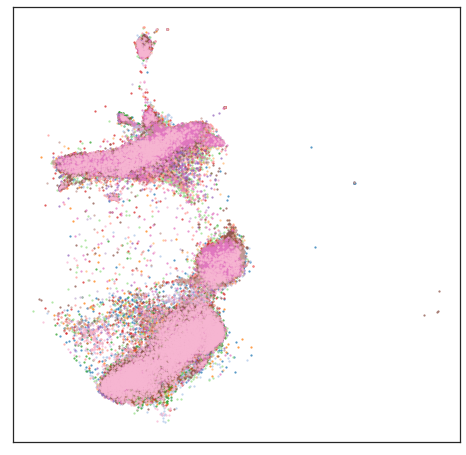

In [18]:
ax = single_cell_plot(data=data,
                      x="UMAP1",
                      y="UMAP2",
                      label="sample_id",
                      discrete=True,
                      linewidth=0,
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/after_correction.png", dpi=300, bbox_inches="tight", facecolor="white")

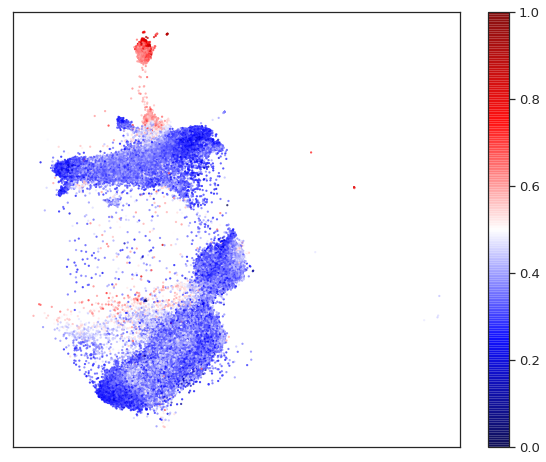

In [19]:
data["PanGD + Vd2"] = data["PanGD"] + data["Vd2"]
ax = single_cell_plot(data=data,
                      x="UMAP1",
                      y="UMAP2",
                      label="PanGD + Vd2",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      cmap="seismic",
                      norm=Normalize(vmin=0, vmax=1),
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/after_correction_GDT.png", dpi=300, bbox_inches="tight", facecolor="white")

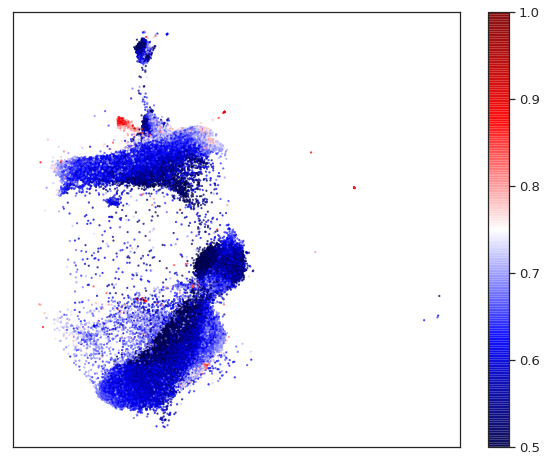

In [20]:
data["CD161 + Va7-2"] = data["CD161"] + data["Va7-2"]
ax = single_cell_plot(data=data,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD161 + Va7-2",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      cmap="seismic",
                      norm=Normalize(vmin=0.5, vmax=1),
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/after_correction_MAIT.png", dpi=300, bbox_inches="tight", facecolor="white")

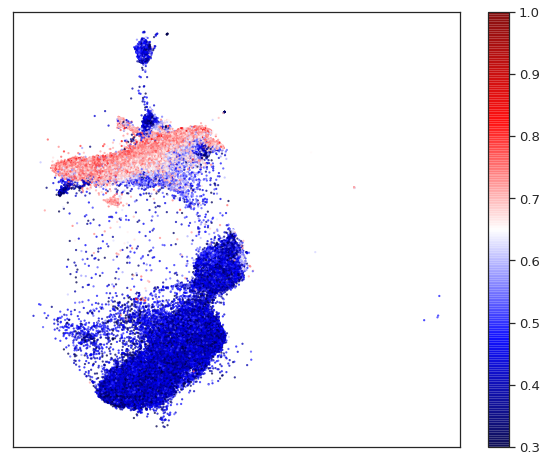

In [21]:
ax = single_cell_plot(data=data,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD8",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      cmap="seismic",
                      norm=Normalize(vmin=0.3, vmax=1),
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/after_correction_CD8.png", dpi=300, bbox_inches="tight", facecolor="white")

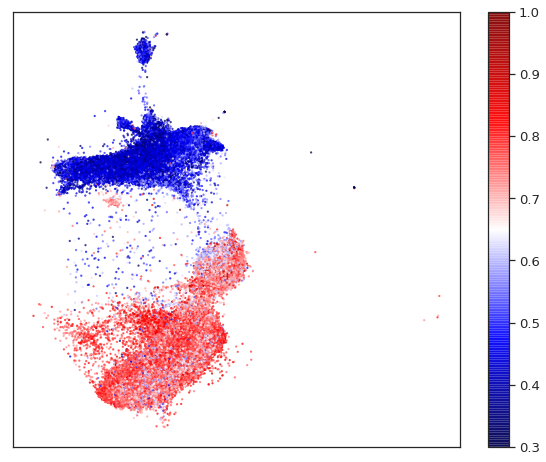

In [22]:
ax = single_cell_plot(data=data,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD4",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      cmap="seismic",
                      norm=Normalize(vmin=0.3, vmax=1),
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/after_correction_CD4.png", dpi=300, bbox_inches="tight", facecolor="white")

<h3>Saving results</h3>

Saving our corrected data is simple. We specify the experiment we want to save to (the one we created earlier) and the data is saved to new `FileGroup`'s created within this experiment. Inverse transformation and scaling is performed and the data is saved in linear space, such that any transformation of interest can be performed on the data at a later point.

In [28]:
harmony.save(experiment=peritonitis_project.load_experiment("Corrected PBMC T cells"))

  0%|          | 0/14 [00:00<?, ?it/s]